In [1]:
import numpy as np 
import pandas as pd 
import os
from matplotlib import pyplot as plt
import torch
import cv2

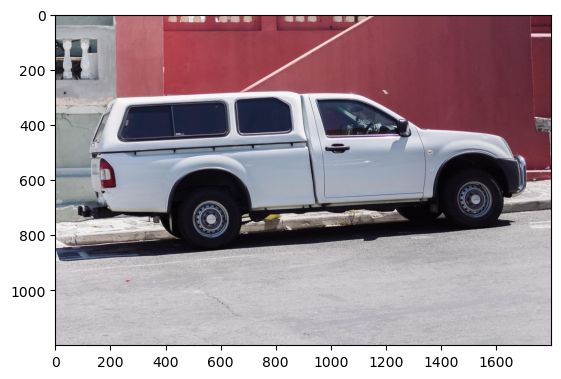

In [2]:
# import test image from images/truck.jpg
img = cv2.imread('images/truck.jpg')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
plt.imshow(img)

In [3]:
from segment_anything import sam_model_registry, SamAutomaticMaskGenerator, SamPredictor, SamEncoder

model_type = "vit_b"
sam_checkpoint = "sam_vit_b.pth"

sam = sam_model_registry[model_type](checkpoint=sam_checkpoint)

In [4]:
predictor = SamPredictor(sam)
predictor.set_image(img)
features = predictor.features


In [5]:
from torchvision.transforms.functional import resize, to_pil_image  # type: ignore
from typing import Tuple

def get_preprocess_shape(oldh: int, oldw: int, long_side_length: int) -> Tuple[int, int]:
    """
    Compute the output size given input size and target long side length.
    """
    scale = long_side_length * 1.0 / max(oldh, oldw)
    newh, neww = oldh * scale, oldw * scale
    neww = int(neww + 0.5)
    newh = int(newh + 0.5)
    return (newh, neww)

def apply_image(image: np.ndarray, target_length: int) -> np.ndarray:
    """
    Expects a numpy array with shape HxWxC in uint8 format.
    """
    target_size = get_preprocess_shape(image.shape[0], image.shape[1], target_length)
    return np.array(resize(to_pil_image(image), target_size))


In [6]:
applied_image = apply_image(img, 1024)
# convert numpy img to tensor
img_tensor = torch.as_tensor(applied_image)
print(img_tensor.shape)
# convert to BxCxHxW format expected by model
# img_tensor = img_tensor.permute(2, 0, 1).contiguous()[None, :, :, :]
# print(img_tensor.shape)

torch.Size([683, 1024, 3])


In [7]:
encoder = SamEncoder(sam)
encoded = encoder(img_tensor)

INITIALIZING SAM PREDICTOR
RUNNING FORWARD


In [11]:
# compare encoded and features shape

print(encoded.shape)
print(features.shape)

for i in range(10):
    print(encoded[0, 0, 0, i])
    print(features[0, 0, 0, i])

tolerance = 0.001  # Set the tolerance value
are_equal = torch.allclose(features, encoded, atol=tolerance)
print(are_equal)

torch.Size([1, 256, 64, 64])
torch.Size([1, 256, 64, 64])
tensor(-0.0026)
tensor(-0.0026)
tensor(0.0052)
tensor(0.0052)
tensor(-0.0093)
tensor(-0.0093)
tensor(-0.0016)
tensor(-0.0016)
tensor(-0.0046)
tensor(-0.0046)
tensor(-0.0031)
tensor(-0.0031)
tensor(-0.0058)
tensor(-0.0058)
tensor(-0.0429)
tensor(-0.0429)
tensor(-0.0178)
tensor(-0.0178)
tensor(-0.0282)
tensor(-0.0282)
True


In [12]:
# Dummy input for trace:

print(img.shape)
size = (1280, 720, 3)
dummy_img = np.random.randint(low=0, high=226, size=size, dtype=np.uint8)
print(dummy_img.shape)

(1200, 1800, 3)
(1280, 720, 3)


In [13]:
# for comparison
predictor.set_image(dummy_img)
features = predictor.features

In [14]:
applied_dummy_image = apply_image(dummy_img, 1024)
# convert numpy img to tensor
dummy_tensor = torch.as_tensor(applied_dummy_image)
print(dummy_tensor.shape)
# convert to BxCxHxW format expected by model
# dummy_tensor = dummy_tensor.permute(2, 0, 1).contiguous()[None, :, :, :]


torch.Size([1024, 576, 3])


In [15]:
encoded = encoder(dummy_tensor)

RUNNING FORWARD


In [17]:
# tensors are shape 1, 256, 64, 64
# print a few values of each
# run a for loop
for i in range(10):
    print(encoded[0, 0, 0, i])
    print(features[0, 0, 0, i])


# compare encoded and features with torch
tolerance = 0.100  # Set the tolerance value
are_equal = torch.allclose(features, encoded, atol=tolerance)
print(are_equal)

tensor(-0.0424)
tensor(-0.0424)
tensor(-0.0252)
tensor(-0.0252)
tensor(-0.0313)
tensor(-0.0313)
tensor(-0.0516)
tensor(-0.0516)
tensor(-0.0539)
tensor(-0.0539)
tensor(-0.0446)
tensor(-0.0446)
tensor(-0.0318)
tensor(-0.0318)
tensor(-0.0374)
tensor(-0.0374)
tensor(-0.0372)
tensor(-0.0372)
tensor(-0.0260)
tensor(-0.0260)
True


In [59]:
encoder.eval()
traced_model = torch.jit.trace(encoder, dummy_tensor)

RUNNING FORWARD


/Users/christinebarron/Proj/BarronHealth/ML/segment-anything/segment_anything/encoder.py:78: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  and transformed_image.shape[1] == 3
/Users/christinebarron/Proj/BarronHealth/ML/segment-anything/segment_anything/encoder.py:79: TracerWarning: Converting a tensor to a Python boolean might cause the trace to be incorrect. We can't record the data flow of Python values, so this value will be treated as a constant in the future. This means that the trace might not generalize to other inputs!
  and max(*transformed_image.shape[2:]) == self.model.image_encoder.img_size
/Users/christinebarron/Proj/BarronHealth/ML/segment-anything/segment_anything/modeling/image_encoder.py:258: TracerWarning: Converting a tensor to a Python boolean might

RUNNING FORWARD
RUNNING FORWARD


In [60]:
# try running the dummy input to the traced model, and compare to encoded
traced_output = traced_model(dummy_tensor)

In [61]:
are_equal = torch.allclose(encoded, traced_output, atol=tolerance)
print(are_equal)

True


In [62]:
for i in range(10):
    print(traced_output[0, 0, 0, i])
    print(features[0, 0, 0, i])

tensor(-0.0424, grad_fn=<SelectBackward0>)
tensor(-0.0424)
tensor(-0.0252, grad_fn=<SelectBackward0>)
tensor(-0.0252)
tensor(-0.0313, grad_fn=<SelectBackward0>)
tensor(-0.0313)
tensor(-0.0516, grad_fn=<SelectBackward0>)
tensor(-0.0516)
tensor(-0.0539, grad_fn=<SelectBackward0>)
tensor(-0.0539)
tensor(-0.0446, grad_fn=<SelectBackward0>)
tensor(-0.0446)
tensor(-0.0318, grad_fn=<SelectBackward0>)
tensor(-0.0318)
tensor(-0.0374, grad_fn=<SelectBackward0>)
tensor(-0.0374)
tensor(-0.0372, grad_fn=<SelectBackward0>)
tensor(-0.0372)
tensor(-0.0260, grad_fn=<SelectBackward0>)
tensor(-0.0260)


In [1]:
# output to coreml

traced_model.eval()

import coremltools as ct
coreml_model = ct.convert(
    traced_model,
    convert_to="mlprogram",
    inputs=[ct.ImageType(name="colorImage",
            shape=dummy_tensor.shape,
            color_layout=ct.colorlayout.RGB,)],
    # inputs=[ct.TensorType(shape=dummy_tensor.shape)]
)

NameError: name 'traced_model' is not defined

In [ ]:
# coreml_model.save("SamEncoder.mlpackage")
coreml_model.save("SamEncoder.mlmodel")

In [ ]:
# to run the coreml model, convert the dummy_tensor to a numpy array with 16 bit floats
desired_shape = dummy_tensor.shape
print(desired_shape)
print(input.shape)

coreml_output = coreml_model.predict({"image_1": dummy_tensor.numpy().astype(np.float32)})
print(coreml_output.keys())

torch.Size([1024, 576, 3])
(1024, 576, 3)
dict_keys(['var_2247'])


In [54]:
# compare coreml output to traced output
# convert coreml output to tensor
coreml_output_tensor = torch.as_tensor(coreml_output["var_2247"])

In [55]:
# compare coreml output to traced output
for i in range(10):
    print(coreml_output_tensor[0, 0, 0, i])
    print(traced_output[0, 0, 0, i])

tensor(-0.0424)
tensor(-0.0424, grad_fn=<SelectBackward0>)
tensor(-0.0252)
tensor(-0.0252, grad_fn=<SelectBackward0>)
tensor(-0.0312)
tensor(-0.0313, grad_fn=<SelectBackward0>)
tensor(-0.0516)
tensor(-0.0516, grad_fn=<SelectBackward0>)
tensor(-0.0541)
tensor(-0.0539, grad_fn=<SelectBackward0>)
tensor(-0.0444)
tensor(-0.0446, grad_fn=<SelectBackward0>)
tensor(-0.0318)
tensor(-0.0318, grad_fn=<SelectBackward0>)
tensor(-0.0371)
tensor(-0.0374, grad_fn=<SelectBackward0>)
tensor(-0.0371)
tensor(-0.0372, grad_fn=<SelectBackward0>)
tensor(-0.0258)
tensor(-0.0260, grad_fn=<SelectBackward0>)


In [ ]:
# Now try and run the second part of the model:
